In [1]:
import pyspark

In [11]:
import sys, os
from pyspark.sql import SparkSession
#配置python路径
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYSPARK_PYTHON"] = sys.executable
spark = (SparkSession.builder
         .master("local[*]")
         .appName("lab")
         .config("spark.driver.host", "127.0.0.1")
         .config("spark.driver.bindAddress", "127.0.0.1")
         .config("spark.pyspark.driver.python", sys.executable)
         .config("spark.pyspark.python", sys.executable)
         .getOrCreate()
         )
print("python:", sys.executable)
print("PYSPARK_PYTHON:", os.environ.get("PYSPARK_PYTHON"))
print("PYSPARK_DRIVER_PYTHON:", os.environ.get("PYSPARK_DRIVER_PYTHON"))
sc = pyspark.SparkContext.getOrCreate()

python: E:\Python3.11\python.exe
PYSPARK_PYTHON: E:\Python3.11\python.exe
PYSPARK_DRIVER_PYTHON: E:\Python3.11\python.exe


# Example (Word Count)

In [19]:
rdd = sc.textFile("big-data/example.txt") # Load the text file into pyspark

word_counts_rdd = (
    rdd
        .flatMap(lambda line: line.split(" ")) # Map a single value (line) to multiple values (words)
        .map(lambda word: (word, 1))
        .reduceByKey(lambda a,b: a + b) # Group all K,V pairs by key and sum up the counts
)

# Spark is lazy. The transformations are only computed as soon as we call `collect`
print(sorted(word_counts_rdd.collect()))

[('', 23), ('At', 12), ('Consetetur', 1), ('Duis', 6), ('Lorem', 26), ('Nam', 2), ('Stet', 12), ('Ut', 4), ('accumsan', 4), ('accusam', 12), ('ad', 4), ('adipiscing', 4), ('aliquam', 4), ('aliquip', 4), ('aliquyam', 12), ('amet,', 15), ('amet.', 11), ('assum.', 2), ('at', 4), ('augue', 4), ('autem', 6), ('blandit', 4), ('clita', 12), ('commodo', 4), ('congue', 2), ('consectetuer', 4), ('consequat,', 5), ('consequat.', 4), ('consetetur', 11), ('cum', 2), ('delenit', 4), ('diam', 27), ('dignissim', 4), ('dolor', 32), ('dolore', 25), ('dolores', 12), ('doming', 2), ('duis', 4), ('duo', 12), ('ea', 16), ('eirmod', 12), ('eleifend', 2), ('elit,', 4), ('elitr,', 12), ('enim', 4), ('eos', 12), ('erat', 4), ('erat,', 11), ('erat.', 1), ('eros', 4), ('esse', 5), ('est', 11), ('et', 56), ('eu', 5), ('euismod', 4), ('eum', 6), ('ex', 4), ('exerci', 4), ('facer', 2), ('facilisi.', 4), ('facilisis', 4), ('facilisis.', 1), ('feugait', 4), ('feugiat', 5), ('gubergren,', 12), ('hendrerit', 5), ('id', 

# DFG Discovery

## a)

### (ii)

num edges: 75
sample: [(('Create Fine', 'Send Fine'), 99811), (('Send Fine', 'Insert Fine Notification'), 79247), (('Insert Fine Notification', 'Add penalty'), 71019), (('Add penalty', 'Send for Credit Collection'), 47236), (('Create Fine', 'Payment'), 46784), (('Add penalty', 'Payment'), 18476), (('Send for Credit Collection', 'Create Fine'), 14365), (('Payment', 'Payment'), 4254), (('Insert Fine Notification', 'Payment'), 3873), (('Payment', 'Add penalty'), 3853)]


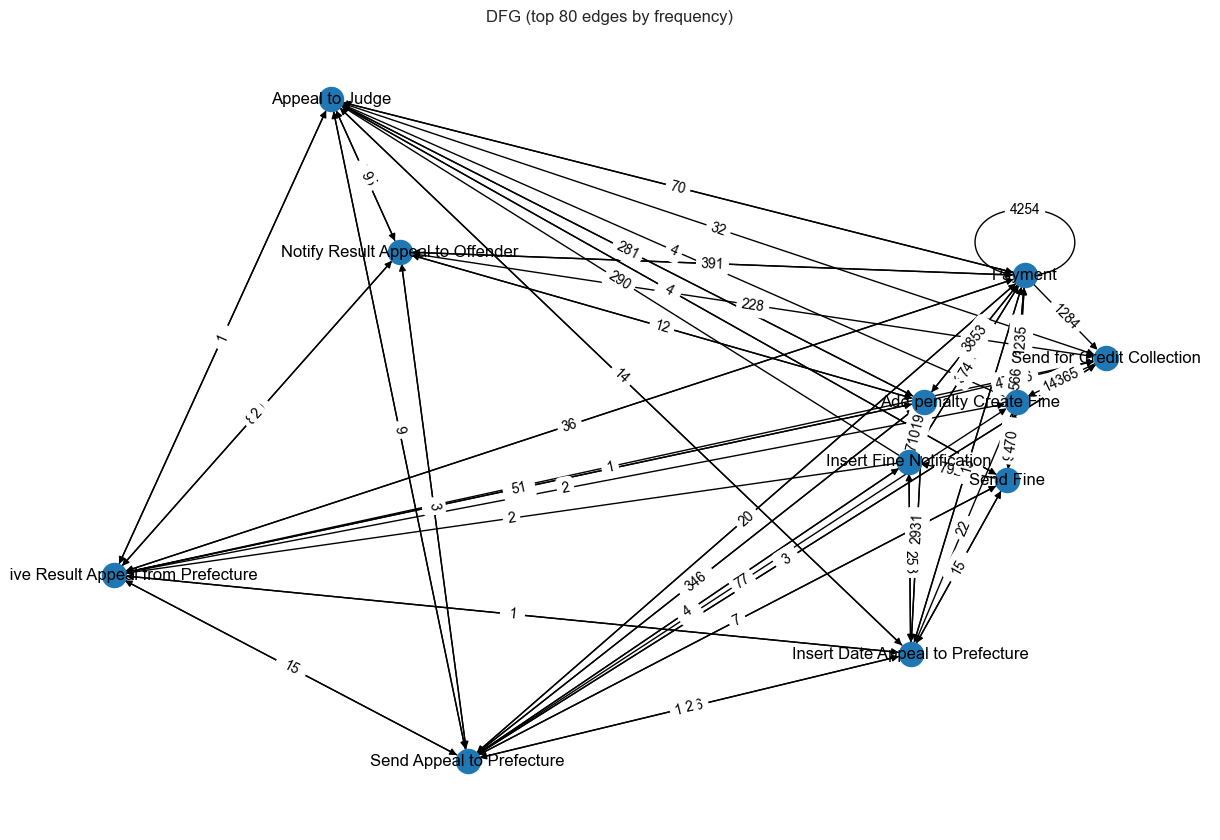

In [21]:
import pyspark
import networkx as nx
import matplotlib.pyplot as plt

sc = pyspark.SparkContext.getOrCreate()

# ✅ 读压缩文件
rdd = sc.textFile("big-data/event_log.csv.gz")

def parse_line(line: str):
    # 列顺序：CaseID, Activity, Timestamp, Resource（无表头）
    parts = line.split(",")
    case_id = parts[0]
    activity = parts[1]
    ts = parts[2]          # 通常 ISO 字符串直接排序也可；更稳可转成可比较类型
    return (case_id, (ts, activity))

parsed = rdd.map(parse_line)

# (case, Iterable[(ts, act)])
by_case = parsed.groupByKey()

# (case, [a1, a2, ...])  —— case 内按 ts 排序得到活动序列
traces = by_case.mapValues(lambda evs: [act for (ts, act) in sorted(evs, key=lambda x: x[0])])

# 生成相邻边：((a,b), 1)
edges = traces.flatMap(
    lambda kv: [((kv[1][i], kv[1][i+1]), 1) for i in range(len(kv[1]) - 1)]
)

# 统计边频次：((a,b), count)
dfg_counts = edges.reduceByKey(lambda a, b: a + b)

# 拉回本地查看/画图
dfg_local = dfg_counts.collect()
print("num edges:", len(dfg_local))
print("sample:", sorted(dfg_local, key=lambda x: -x[1])[:10])
#画图
N = 80
top_edges = sorted(dfg_local, key=lambda x: x[1], reverse=True)[:N]

G = nx.DiGraph()
for (a, b), w in top_edges:
    G.add_edge(a, b, weight=w)

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, arrows=True)
edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title(f"DFG (top {N} edges by frequency)")
plt.show()

## (iii)

num filtered edges: 30
top 10: [(('Create Fine', 'Send Fine'), 99811), (('Send Fine', 'Insert Fine Notification'), 79247), (('Insert Fine Notification', 'Add penalty'), 71019), (('Add penalty', 'Send for Credit Collection'), 47236), (('Create Fine', 'Payment'), 46784), (('Add penalty', 'Payment'), 18476), (('Send for Credit Collection', 'Create Fine'), 14365), (('Payment', 'Payment'), 4254), (('Insert Fine Notification', 'Payment'), 3873), (('Payment', 'Add penalty'), 3853)]


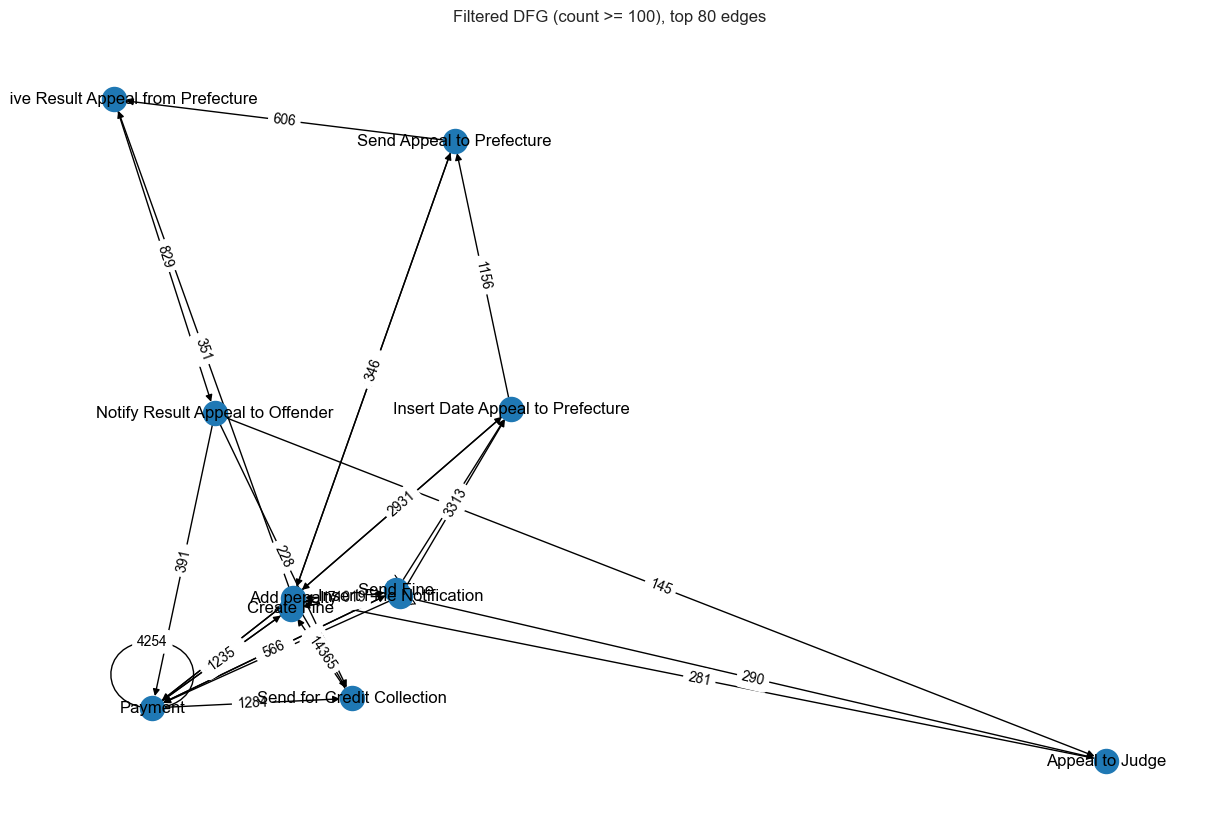

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
# dfg_counts: RDD[((a,b), count)]  来自 Q5(b)
dfg_filtered = dfg_counts.filter(lambda kv: kv[1] >= 100)

dfg_filtered_local = dfg_filtered.collect()
print("num filtered edges:", len(dfg_filtered_local))
print("top 10:", sorted(dfg_filtered_local, key=lambda x: -x[1])[:10])

# 过滤后可能仍然很多边，建议再画 top-N（更清晰）
N = 80
top_edges = sorted(dfg_filtered_local, key=lambda x: x[1], reverse=True)[:N]

G = nx.DiGraph()
for (a, b), w in top_edges:
    G.add_edge(a, b, weight=w)

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, arrows=True)
edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title(f"Filtered DFG (count >= 100), top {N} edges")
plt.show()


# (iv)

In [26]:
# (activity, resource)
act_res = rdd.map(parse_line)

# ((activity, resource), 1) -> count
pair_counts = (
    act_res
    .map(lambda ar: ((ar[0], ar[1]), 1))
    .reduceByKey(lambda a, b: a + b)
)

# (activity, (resource, count))
by_activity = pair_counts.map(lambda kv: (kv[0][0], (kv[0][1], kv[1])))

# 选每个 activity 的最大 count；若 count 相同，用 resource 字典序做稳定 tie-break
def pick_best(x, y):
    # x,y: (resource, count)
    if x[1] != y[1]:
        return x if x[1] > y[1] else y
    return x if x[0] <= y[0] else y

most_common_resource = by_activity.reduceByKey(pick_best)

# 输出：(activity, resource, count)
result = (
    most_common_resource
    .map(lambda kv: (kv[0], kv[1][0], kv[1][1]))
    .sortBy(lambda x: x[0])   # 按 activity 排序，报告更整齐
    .collect()
)

result[:10], len(result)


([('A1', ('1153692000.0', 'Create Fine'), 1),
  ('A100', ('1154469600.0', 'Create Fine'), 1),
  ('A10000', ('1173394800.0', 'Create Fine'), 1),
  ('A10001', ('1174258800.0', 'Create Fine'), 1),
  ('A10004', ('1174345200.0', 'Create Fine'), 1),
  ('A10005', ('1174345200.0', 'Create Fine'), 1),
  ('A10007', ('1174345200.0', 'Create Fine'), 1),
  ('A10008', ('1174345200.0', 'Create Fine'), 1),
  ('A10009', ('1174345200.0', 'Create Fine'), 1),
  ('A1001', ('1154469600.0', 'Create Fine'), 1)],
 150370)